<a href="https://colab.research.google.com/github/oscarserc/VISION_por_COMPUTADORA/blob/main/CV_Practica_3a_Localizacion_Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch
import torchvision

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'

In [ ]:

train = torchvision.datasets.VOCDetection('./data', download=True)
len(train)


  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


5717

In [ ]:

classes = ['background','aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']



In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = train[ix]
  img_np = np.array(img)
  anotaciones = label['annotation']['object']
  if type(anotaciones) is not list:
    anotaciones = [anotaciones]
  labels = np.array([classes.index(ann['name']) for ann in anotaciones])
  coordenadas_cajas = [ann['bndbox'] for ann in anotaciones]
  coordenadas_cajas = np.array([[int(bb['xmin']), int(bb['ymin']), int(bb['xmax']) - int(bb['xmin']), int(bb['ymax']) - int(bb['ymin'])] for bb in coordenadas_cajas])
  anotaciones = (labels, coordenadas_cajas)
  return img_np, anotaciones  

def plot_anns(img, anns, ax=None, bg=-1):
  if not ax:
    fig, ax = plt.subplots(figsize=(10,6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      x, y, w, h = bb
      rect = mpatches.Rectangle((x,y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color':'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)  


In [ ]:

def norm(bb, shape):
  h, w = shape
  return np.array([bb[0]/w, bb[1]/h, bb[2]/w, bb[3]/h])

def unnorm(bb, shape):
  h, w = shape
  return np.array([bb[0]*w, bb[1]*h, bb[2]*w, bb[3]*h])  


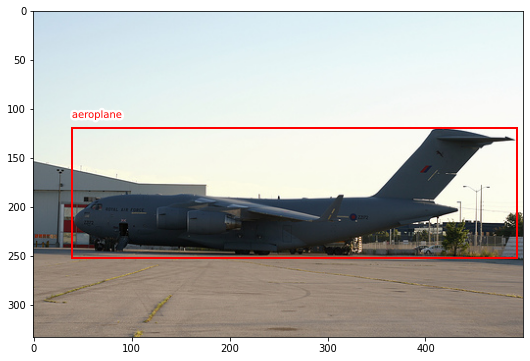

In [ ]:
img_np, anns = get_sample(4445)
plot_anns(img_np, anns)
plt.show()

In [ ]:
anns

(array([1]), array([[ 39, 119, 454, 133]]))

## **Procedemos a construir el MODELO**.

In [ ]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
  return torch.nn.Sequential(
      torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(pk, stride=ps)
  )

def block2(c_in, c_out):
  return torch.nn.Sequential(
      torch.nn.Linear(c_in, c_out),
      torch.nn.ReLU()
  )

class Model(torch.nn.Module):
  def __init__(self, n_classes, n_channels=3):
    super().__init__()
    self.conv1 = block(n_channels, 8)
    self.conv2 = block(8, 16)
    self.conv3 = block(16,32)
    self.conv4 = block(32,64)
    self.fc1 = block2(64*6*6, 100)
    # Una capa de salida para REGRESIÓN y crear la caja
    self.fc2_loc = torch.nn.Linear(100,4)
    # Una capa para realizar la CLASIFICACIÓN del objeto en la imagen
    self.fc2_cls = torch.nn.Linear(100, n_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x_loc = self.fc2_loc(x)
    x_cls = self.fc2_cls(x)
    return x_loc, x_cls


In [ ]:

model = Model(n_classes = len(classes))
salida_loc, salida_cls  = model(torch.randn(64, 3, 100, 100))
salida_loc.shape, salida_cls.shape


(torch.Size([64, 4]), torch.Size([64, 21]))

In [ ]:
salida_cls

tensor([[ 0.0552, -0.0869,  0.0179,  ..., -0.0258,  0.0330,  0.0309],
        [ 0.0560, -0.0901,  0.0224,  ..., -0.0283,  0.0397,  0.0234],
        [ 0.0541, -0.0902,  0.0176,  ..., -0.0215,  0.0363,  0.0260],
        ...,
        [ 0.0554, -0.0866,  0.0164,  ..., -0.0270,  0.0376,  0.0317],
        [ 0.0595, -0.0888,  0.0184,  ..., -0.0183,  0.0376,  0.0297],
        [ 0.0613, -0.0908,  0.0247,  ..., -0.0201,  0.0325,  0.0309]],
       grad_fn=<AddmmBackward0>)

In [ ]:

import albumentations as A

def get_aug(aug, min_area=0., min_visibility=0.):
  return A.Compose(aug, bbox_params={'format': 'coco',
                                     'min_area': min_area,
                                     'min_visibility': min_visibility,
                                     'label_fields': ['labels']})
trans = get_aug([A.Resize(100,100)])

labels, bbs = anns
augmented = trans(**{'image': img_np, 'bboxes': bbs, 'labels': labels})
img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels']

img.shape, bbs, labels



((100, 100, 3), [[7.8, 35.73573573573574, 90.8, 39.93993993993994]], [1])

In [ ]:
bb, label = bbs[0], labels[0]
bb, label

([7.8, 35.73573573573574, 90.8, 39.93993993993994], 1)

In [ ]:
bb_norm = norm(bb, img.shape[:2])
bb_norm

array([0.078     , 0.35735736, 0.908     , 0.3993994 ])

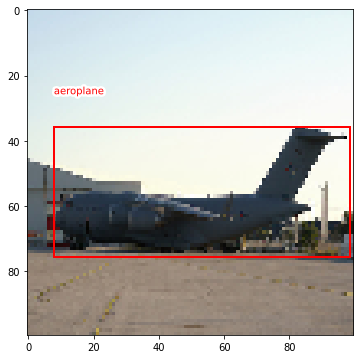

In [ ]:

# AHORA DIBUJAMOS UNA DE LAS IMÁGENES
# -----------------------------------

plot_anns(img, (labels, bbs))
plt.show()



## **FIT del modelo**.

In [ ]:

def fit(model, X, y1, y2, epochs=1, lr=1e-3):
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion_loc = torch.nn.L1Loss()
  criterion_cls = torch.nn.CrossEntropyLoss()

  for epoch in range(1, epochs+1):
    model.train()         #    <--------------------- MODO ENTRENAMIENTO
    train_loss_loc, train_loss_cls = [], []
    X, y1, y2 = X.to(device), y1.to(device), y2.to(device)

    y_hat1, y_hat2 = model(X)
    loss_loc = criterion_loc(y_hat1, y1)
    loss_cls = criterion_cls(y_hat2, y2)
    loss = loss_loc + loss_cls

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_loc.append(loss_loc.item())
    train_loss_cls.append(loss_cls.item())
    print(f'Epoch {epoch}/{epochs} loss_loc {np.mean(train_loss_loc):.5f} loss_cls {np.mean(train_loss_cls):.5f}')



In [ ]:

# PROCEDEMOS AL ENTRENAMIENTO de una imagen (Veremos si es capaza de calibrar bien la caja de LOCALIZACIÓN y CLASIFICAR lo que encuentra)
# ---------------------------

modelo = Model(n_classes = len(classes))
img_tensor   = torch.FloatTensor(img/255.).permute(2,0,1).unsqueeze(0)
bb_tensor    = torch.FloatTensor(bb_norm).unsqueeze(0)
label_tensor = torch.tensor(label).long().unsqueeze(0)

fit(model, img_tensor, bb_tensor, label_tensor, epochs=30)


Epoch 1/30 loss_loc 0.46301 loss_cls 3.14272
Epoch 2/30 loss_loc 0.44293 loss_cls 3.04637
Epoch 3/30 loss_loc 0.41658 loss_cls 2.94511
Epoch 4/30 loss_loc 0.38915 loss_cls 2.79041
Epoch 5/30 loss_loc 0.36024 loss_cls 2.56817
Epoch 6/30 loss_loc 0.30449 loss_cls 2.24419
Epoch 7/30 loss_loc 0.21093 loss_cls 1.79481
Epoch 8/30 loss_loc 0.26330 loss_cls 1.21895
Epoch 9/30 loss_loc 0.34969 loss_cls 0.59476
Epoch 10/30 loss_loc 0.58049 loss_cls 0.16925
Epoch 11/30 loss_loc 0.69999 loss_cls 0.03818
Epoch 12/30 loss_loc 0.70269 loss_cls 0.01179
Epoch 13/30 loss_loc 0.62957 loss_cls 0.00528
Epoch 14/30 loss_loc 0.60172 loss_cls 0.00339
Epoch 15/30 loss_loc 0.50062 loss_cls 0.00274
Epoch 16/30 loss_loc 0.31973 loss_cls 0.00262
Epoch 17/30 loss_loc 0.12504 loss_cls 0.00276
Epoch 18/30 loss_loc 0.18780 loss_cls 0.00335
Epoch 19/30 loss_loc 0.24774 loss_cls 0.00391
Epoch 20/30 loss_loc 0.25930 loss_cls 0.00424
Epoch 21/30 loss_loc 0.27067 loss_cls 0.00466
Epoch 22/30 loss_loc 0.28591 loss_cls 0.005

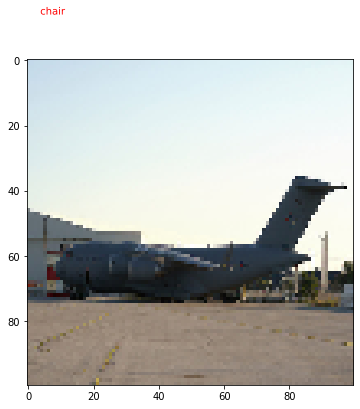

In [ ]:

modelo.eval()
pred_bb_norm, pred_cls = modelo(img_tensor.to(device))
pred_bb = unnorm(pred_bb_norm[0].detach().numpy(), img.shape[:2])
pred_cls = torch.argmax(pred_cls, axis=1)[0]

plot_anns(img, ([pred_cls], [pred_bb]))
plt.show()

